# QRS Complex Dectition Algorithm


## Acquiring the Data

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")

df = df[:40000]


# # Plot the data
# plt.figure(figsize=(10, 6))
# plt.plot(time, data)
# plt.xlabel('Time')
# plt.ylabel('Data')
# plt.title('ECG Data from Joaquin Philco')
# plt.grid(True)
# plt.show()

df.head()


,sec,CH1,CH40,Unnamed: 3
0,0.000,-0.120850,0.0,NaN
1,0.001,-0.123596,0.0,NaN
2,0.002,-0.126343,0.0,NaN
3,0.003,-0.129395,0.0,NaN
4,0.004,-0.131836,0.0,NaN


## Cleaning the Dataset

In [276]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

# Only use the first 40,000 entries
df_subset = df.iloc[:40000]

df.head()

,sec,CH1
0,0.000,-0.120850
1,0.001,-0.123596
2,0.002,-0.126343
3,0.003,-0.129395
4,0.004,-0.131836


## Rate of Change Function
This function gets the first and second derivative of the original given signal and adds their absolute components together, to take a look at the rate of change of the data. The QRS component of each beat can be identified by the largest peakls in the plot. 

The function steps:
--> Gets first derivative
--> Gets second derivative
--> Adds absolute values of first and second derivative
--> Transnforms to frequency domain
--> applies a low pass filter to the data
--> return to time domain
--> plots the rate of change
--> returns both x and y components of the rate of change plot

In [277]:
def rate_of_change(signal_x, signal_y):

    # remove dc component
    signal_y = signal_y - np.sum(signal_y)/len(signal_y)

    # Compute the first derivative
    first_derivative = np.gradient(signal_y, signal_x)

    # Compute the second derivative
    second_derivative = np.gradient(first_derivative, signal_x)

    roc_data = abs(first_derivative) + abs(second_derivative)

    # Find the frequency domain components
    fft_result = np.fft.fft(roc_data)

    # Compute the frequencies corresponding to the FFT result
    n = len(roc_data)
    freq = np.fft.fftfreq(n, d=(signal_x[1] - signal_x[0]))

    # Define the cutoff frequency for the low-pass filter
    cutoff_freq = 25  # Adjust this value according to your requirements

    # Create the low-pass filter
    lowpass_filter = np.zeros_like(freq)
    lowpass_filter[np.abs(freq) <= cutoff_freq] = 1

    # Apply the low-pass filter to the FFT result
    filtered_fft_result = fft_result * lowpass_filter

    # Compute the inverse FFT (return to time domain)
    ifft_result = np.fft.ifft(filtered_fft_result)

    # Plot the rate of change plot
    plt.figure(figsize=(10, 6))
    plt.plot(signal_x, np.real(ifft_result))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Rate of Change Plot')
    plt.grid(True)
    plt.show()

    return signal_x, np.real(ifft_result)

## QRS Detection

In [278]:
def qrs_detection(x_data, y_data):
    # Get the maximum and minimum y values
    max_value = np.max(y_data)
    min_value = np.min(y_data)

    # Find the middle y value and use it as threshold
    threshold = ((max_value - min_value) / 2) - 2000

    # Initialize a list to store the new y_data
    y_qrs_detected_binary = []
    x_qrs_detected = []
    y_qrs_detected = []

    # Iterate through data
    for x,y in zip(x_data,y_data):
        if y > threshold:
            y_qrs_detected_binary.append(1)
            y_qrs_detected.append(y)
            x_qrs_detected.append(x)
        else:
            y_qrs_detected_binary.append(0)

    # Plot the values
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, label='QRS Detected', color='blue')
    plt.scatter(x_qrs_detected, y_qrs_detected, color='red', label='Above Threshold')
    plt.xlabel('Time')
    plt.ylabel('QRS Detection')
    plt.title('QRS Detection Result')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_data, y_qrs_detected_binary, y_qrs_detected


## Get More Feature Columns from Dataset

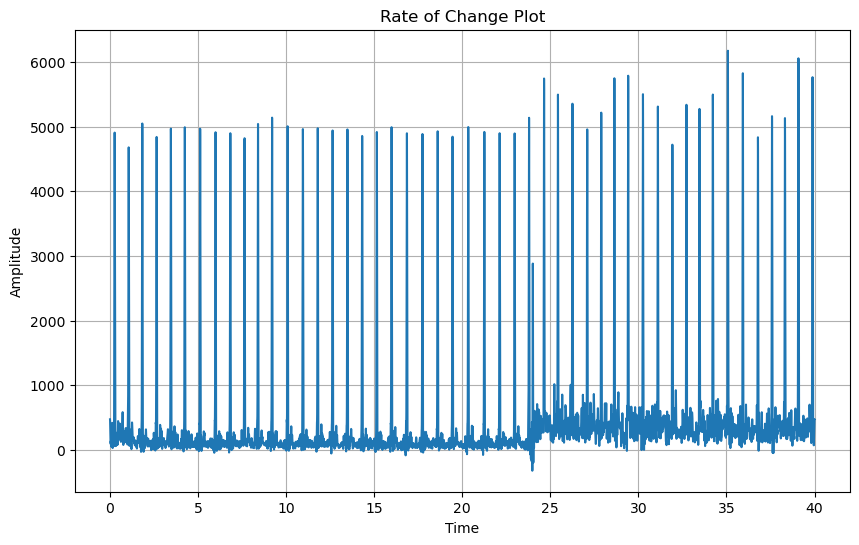

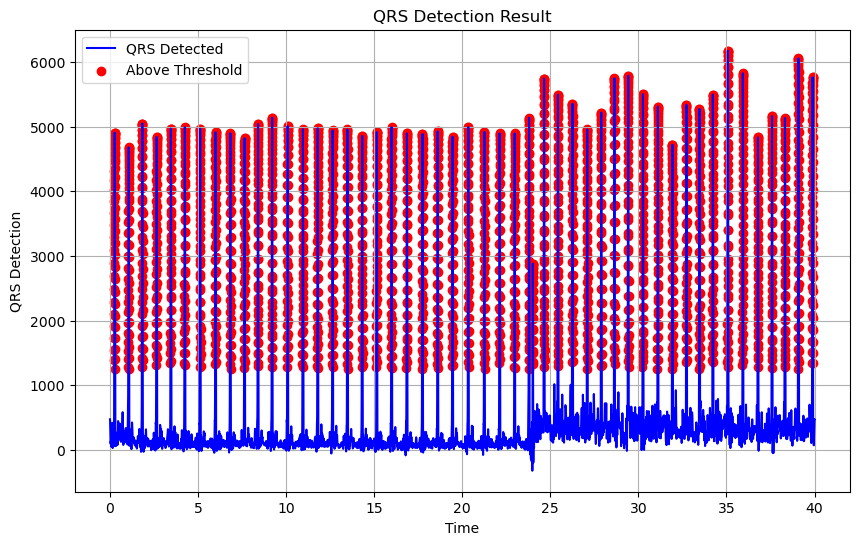

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sec                  40000 non-null  float64
 1   CH1                  40000 non-null  float64
 2   Rate_of_change       40000 non-null  float64
 3   QRS_detected_binary  40000 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.2 MB


In [279]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

[x_data, y_data] = rate_of_change(time[:40000], data[:40000])

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

# Find the QRS Complexes thorugh rate of change
[qrs_x, qrs_y_binary, qrs_y] = qrs_detection(x_data, y_data)

# QRS Binary data frame
qrs_df_binary = pd.DataFrame({'QRS_detected_binary': qrs_y_binary})

# QRS Value dataframe
# qrs_df = pd.DataFrame({'QRS_detected_value': qrs_y})

# Add them to the dataset 
df = pd.concat([df, qrs_df_binary], axis=1)
# df = pd.concat([df, qrs_df], axis=1)

df.head()
df.info()



## Preprocessing Pipeline


In [280]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [281]:
# Assuming numerical_columns and categorical_columns are lists of column names
numerical_columns = df.select_dtypes(include='number').columns.to_list()

#exclude the target from numerical columns
numerical_columns.remove("QRS_detected_binary")


# Create preprocessing pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])


# Combine preprocessing pipelines for numerical columns
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns)],
    remainder='passthrough')

# Display the preprocessing pipeline
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['sec', 'CH1', 'Rate_of_change'])])

In [282]:
# # Apply the preprocessing pipeline on the dataset
df_prepared = preprocessing_pipeline.fit_transform(df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing_pipeline.get_feature_names_out()
df_prepared = pd.DataFrame(data=df_prepared, columns=feature_names)

df_prepared

,numerical__sec,numerical__CH1,numerical__Rate_of_change,remainder__QRS_detected_binary
0,-1.732008,-0.785112,0.051355,0.0
1,-1.731921,-0.805844,0.048897,0.0
2,-1.731834,-0.826583,0.045225,0.0
3,-1.731748,-0.849625,0.040242,0.0
4,-1.731661,-0.868054,0.033865,0.0
...,...,...,...,...
39995,1.731661,0.588073,0.049251,0.0
39996,1.731748,0.622632,0.051223,0.0
39997,1.731834,0.664105,0.052527,0.0
39998,1.731921,0.710184,0.053057,0.0


## Labeling Data for Training

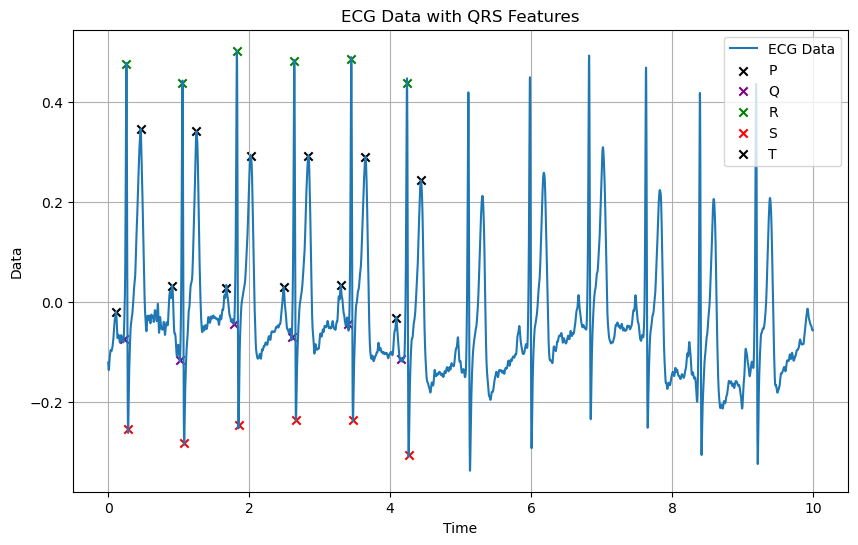

In [283]:
import numpy as np
from scipy.signal import find_peaks

time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

time_subset = time[:10000]

df_subset = data[:10000]


p_indices = [110, 910, 1670, 2490, 3300, 4085]
q_indices = [219, 1018, 1785, 2605, 3400, 4160]
r_indices = [257, 1052, 1825, 2641, 3450, 4238]
s_indices = [284, 1079, 1851, 2663, 3474, 4265]
t_indices = [460, 1250, 2020, 2840, 3650, 4436]

# Plot the ECG signal
plt.figure(figsize=(10, 6))
plt.plot(time_subset, df_subset, label='ECG Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data from Joaquin Philco')
plt.grid(True)


# Marking P Features
plt.scatter(time_subset[p_indices], df_subset[p_indices], color='black', marker='x', label='P')

# Marking Q Features
plt.scatter(time_subset[q_indices], df_subset[q_indices], color='purple', marker='x', label='Q')

# Marking R Features
plt.scatter(time_subset[r_indices], df_subset[r_indices], color='green', marker='x', label='R')

# Marking S Features
plt.scatter(time_subset[s_indices], df_subset[s_indices], color='red', marker='x', label='S')

# Marking T Features
plt.scatter(time_subset[t_indices], df_subset[t_indices], color='black', marker='x', label='T')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data with QRS Features')
plt.legend()
plt.grid(True)
plt.show()
